# Importing Necessary Libraries

In [61]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report, f1_score, confusion_matrix
from sklearn.decomposition import PCA
from sklearn.ensemble import IsolationForest
from sklearn.metrics import precision_score, recall_score, roc_auc_score
from cryptography.fernet import Fernet
import matplotlib.pyplot as plt
import time


# Loading and Preprocessing Datasets



In [62]:
# Load datasets
embb_data = pd.read_csv('eMBB.csv')
mmtc_data = pd.read_csv('mMTC.csv')
urllc_data = pd.read_csv('URLLC.csv')

# Handle missing values and encode features
def preprocess_dataset(data):
    numeric_data = data.select_dtypes(include=[np.number])
    numeric_data.fillna(numeric_data.mean(), inplace=True)
    non_numeric_data = data.select_dtypes(exclude=[np.number])
    if not non_numeric_data.empty:
        numeric_data = pd.concat(
            [numeric_data, pd.get_dummies(non_numeric_data, drop_first=True)], axis=1
        )
    return numeric_data

# Preprocess all datasets
embb_data = preprocess_dataset(embb_data)
mmtc_data = preprocess_dataset(mmtc_data)
urllc_data = preprocess_dataset(urllc_data)
    

# Scaling Features and Separating Targets


In [63]:
scaler = StandardScaler()

def preprocess(data):
    features = data.iloc[:, :-1]
    target = data.iloc[:, -1]
    features_scaled = scaler.fit_transform(features)
    return features_scaled, target

# Preprocess datasets
embb_features, embb_target = preprocess(embb_data)
mmtc_features, mmtc_target = preprocess(mmtc_data)
urllc_features, urllc_target = preprocess(urllc_data)

# Print shapes
print(f"eMBB Features Shape: {embb_features.shape}, Target Shape: {embb_target.shape}")
print(f"mMTC Features Shape: {mmtc_features.shape}, Target Shape: {mmtc_target.shape}")
print(f"URLLC Features Shape: {urllc_features.shape}, Target Shape: {urllc_target.shape}")


eMBB Features Shape: (5808, 46), Target Shape: (5808,)
mMTC Features Shape: (4615, 52), Target Shape: (4615,)
URLLC Features Shape: (4033, 69), Target Shape: (4033,)


D:\GUC\Semester 9\Data Engineering\Anaconda\lib\site-packages\sklearn\utils\extmath.py:985: RuntimeWarning: invalid value encountered in true_divide
  updated_mean = (last_sum + new_sum) / updated_sample_count
D:\GUC\Semester 9\Data Engineering\Anaconda\lib\site-packages\sklearn\utils\extmath.py:990: RuntimeWarning: invalid value encountered in true_divide
  T = new_sum / new_sample_count
D:\GUC\Semester 9\Data Engineering\Anaconda\lib\site-packages\sklearn\utils\extmath.py:1020: RuntimeWarning: invalid value encountered in true_divide
  new_unnormalized_variance -= correction ** 2 / new_sample_count
D:\GUC\Semester 9\Data Engineering\Anaconda\lib\site-packages\sklearn\utils\extmath.py:985: RuntimeWarning: invalid value encountered in true_divide
  updated_mean = (last_sum + new_sum) / updated_sample_count
D:\GUC\Semester 9\Data Engineering\Anaconda\lib\site-packages\sklearn\utils\extmath.py:990: RuntimeWarning: invalid value encountered in true_divide
  T = new_sum / new_sample_count


# Splitting and Cleaning Data



In [67]:
def split_data(features, target):
    return train_test_split(features, target, test_size=0.2, random_state=42)

embb_x_train, embb_x_test, embb_y_train, embb_y_test = split_data(embb_features, embb_target)
mmtc_x_train, mmtc_x_test, mmtc_y_train, mmtc_y_test = split_data(mmtc_features, mmtc_target)
urllc_x_train, urllc_x_test, urllc_y_train, urllc_y_test = split_data(urllc_features, urllc_target)

# Function to clean the data
def clean_data(features, target):
    # Replace NaN and infinite values
    features = np.nan_to_num(features, nan=0.0, posinf=0.0, neginf=0.0)
    target = np.nan_to_num(target, nan=0.0, posinf=0.0, neginf=0.0)
    return features, target

# Clean each dataset
embb_x_train, embb_y_train = clean_data(embb_x_train, embb_y_train)
mmtc_x_train, mmtc_y_train = clean_data(mmtc_x_train, mmtc_y_train)
urllc_x_train, urllc_y_train = clean_data(urllc_x_train, urllc_y_train)

embb_x_test, embb_y_test = clean_data(embb_x_test, embb_y_test)
mmtc_x_test, mmtc_y_test = clean_data(mmtc_x_test, mmtc_y_test)
urllc_x_test, urllc_y_test = clean_data(urllc_x_test, urllc_y_test)


# Training Random Forest Models


In [68]:
def train_model(x_train, y_train):
    model = RandomForestClassifier(random_state=42)
    model.fit(x_train, y_train)
    return model

# Train models for each slice type
embb_model = train_model(embb_x_train, embb_y_train)
mmtc_model = train_model(mmtc_x_train, mmtc_y_train)
urllc_model = train_model(urllc_x_train, urllc_y_train)


# Making Predictions

In [69]:
# Predict resource needs
def predict_resources(model, x_test):
    return model.predict(x_test)

embb_predictions = predict_resources(embb_model, embb_x_test)
mmtc_predictions = predict_resources(mmtc_model, mmtc_x_test)
urllc_predictions = predict_resources(urllc_model, urllc_x_test)


# Encrypting and Decrypting Data

In [70]:
def encrypt_data(data, key):
    f = Fernet(key)
    return [f.encrypt(str(value).encode()) for value in data]

def decrypt_data(data, key):
    f = Fernet(key)
    return [f.decrypt(value).decode() for value in data]

key = Fernet.generate_key()

# Encrypt and decrypt targets
embb_y_train_encrypted = encrypt_data(embb_y_train, key)
mmtc_y_train_encrypted = encrypt_data(mmtc_y_train, key)
urllc_y_train_encrypted = encrypt_data(urllc_y_train, key)

start_time = time.time()
decrypt_data(embb_y_train_encrypted, key)
encryption_time = time.time() - start_time
print(f"Decryption time: {encryption_time:.4f} seconds")


Decryption time: 1.3212 seconds


# Evaluating Models



In [71]:
def evaluate_model(y_true, y_pred):
    print("Accuracy:", accuracy_score(y_true, y_pred))
    print("F1 Score:", f1_score(y_true, y_pred, average='weighted'))
    print("Classification Report:\n", classification_report(y_true, y_pred))

print("eMBB Evaluation:")
evaluate_model(embb_y_test, embb_predictions)

print("\nmMTC Evaluation:")
evaluate_model(mmtc_y_test, mmtc_predictions)

print("\nURLLC Evaluation:")
evaluate_model(urllc_y_test, urllc_predictions)


eMBB Evaluation:
Accuracy: 0.995697074010327
F1 Score: 0.995696227754005
Classification Report:
               precision    recall  f1-score   support

           0       0.99      1.00      1.00       605
           1       1.00      0.99      1.00       557

    accuracy                           1.00      1162
   macro avg       1.00      1.00      1.00      1162
weighted avg       1.00      1.00      1.00      1162


mMTC Evaluation:
Accuracy: 0.9956663055254604
F1 Score: 0.9956674301580951
Classification Report:
               precision    recall  f1-score   support

           0       1.00      0.99      1.00       517
           1       0.99      1.00      1.00       406

    accuracy                           1.00       923
   macro avg       1.00      1.00      1.00       923
weighted avg       1.00      1.00      1.00       923


URLLC Evaluation:
Accuracy: 1.0
F1 Score: 1.0
Classification Report:
               precision    recall  f1-score   support

           0       1.00

# Simulating Real-World Scenarios


In [72]:
def simulate_real_world_behavior(features, variability=0.1):
    noise = np.random.normal(loc=0.0, scale=variability, size=features.shape)
    return features + noise

simulated_embb_x_test = simulate_real_world_behavior(embb_x_test, variability=0.2)
simulated_mmtc_x_test = simulate_real_world_behavior(mmtc_x_test, variability=0.15)
simulated_urllc_x_test = simulate_real_world_behavior(urllc_x_test, variability=0.05)

# Predictions on simulated data
simulated_embb_predictions = predict_resources(embb_model, simulated_embb_x_test)
simulated_mmtc_predictions = predict_resources(mmtc_model, simulated_mmtc_x_test)
simulated_urllc_predictions = predict_resources(urllc_model, simulated_urllc_x_test)

print("\nSimulated eMBB Evaluation:")
evaluate_model(embb_y_test, simulated_embb_predictions)

print("\nSimulated mMTC Evaluation:")
evaluate_model(mmtc_y_test, simulated_mmtc_predictions)

print("\nSimulated URLLC Evaluation:")
evaluate_model(urllc_y_test, simulated_urllc_predictions)



Simulated eMBB Evaluation:
Accuracy: 0.8691910499139415
F1 Score: 0.8662985167281151
Classification Report:
               precision    recall  f1-score   support

           0       0.80      1.00      0.89       605
           1       1.00      0.73      0.84       557

    accuracy                           0.87      1162
   macro avg       0.90      0.86      0.87      1162
weighted avg       0.89      0.87      0.87      1162


Simulated mMTC Evaluation:
Accuracy: 0.7594799566630552
F1 Score: 0.7358869818098878
Classification Report:
               precision    recall  f1-score   support

           0       0.70      1.00      0.82       517
           1       0.99      0.46      0.62       406

    accuracy                           0.76       923
   macro avg       0.85      0.73      0.72       923
weighted avg       0.83      0.76      0.74       923


Simulated URLLC Evaluation:
Accuracy: 0.9851301115241635
F1 Score: 0.9851538988504822
Classification Report:
               p

# Detecting and Handling Anomalies



In [79]:
def detect_anomalies(features, contamination=0.01):
    detector = IsolationForest(contamination=contamination, random_state=42)
    anomaly_labels = detector.fit_predict(features)
    return anomaly_labels

# Detect anomalies in simulated datasets
embb_anomalies = detect_anomalies(simulated_embb_x_test)
mmtc_anomalies = detect_anomalies(simulated_mmtc_x_test)
urllc_anomalies = detect_anomalies(simulated_urllc_x_test)

# Count anomalies
print("\nAnomalies Detected:")
print(f"eMBB Anomalies: {np.sum(embb_anomalies == -1)}")
print(f"mMTC Anomalies: {np.sum(mmtc_anomalies == -1)}")
print(f"URLLC Anomalies: {np.sum(urllc_anomalies == -1)}")

# Enhance predictions by excluding anomalies
def remove_anomalies(features, labels, anomalies):
    mask = anomalies == 1  # Keep only normal data
    return features[mask], labels[mask]

# Clean datasets
clean_embb_x_test, clean_embb_y_test = remove_anomalies(simulated_embb_x_test, embb_y_test, embb_anomalies)
clean_mmtc_x_test, clean_mmtc_y_test = remove_anomalies(simulated_mmtc_x_test, mmtc_y_test, mmtc_anomalies)
clean_urllc_x_test, clean_urllc_y_test = remove_anomalies(simulated_urllc_x_test, urllc_y_test, urllc_anomalies)

# Predict and evaluate on cleaned data
print("\nEvaluations After Removing Anomalies:")
print("\nCleaned eMBB Evaluation:")
evaluate_model(clean_embb_y_test, predict_resources(embb_model, clean_embb_x_test))

print("\nCleaned mMTC Evaluation:")
evaluate_model(clean_mmtc_y_test, predict_resources(mmtc_model, clean_mmtc_x_test))

print("\nCleaned URLLC Evaluation:")
evaluate_model(clean_urllc_y_test, predict_resources(urllc_model, clean_urllc_x_test))


Anomalies Detected:
eMBB Anomalies: 12
mMTC Anomalies: 10
URLLC Anomalies: 9

Evaluations After Removing Anomalies:

Cleaned eMBB Evaluation:
Accuracy: 0.8678260869565217
F1 Score: 0.8650329493638275
Classification Report:
               precision    recall  f1-score   support

           0       0.80      1.00      0.89       593
           1       1.00      0.73      0.84       557

    accuracy                           0.87      1150
   macro avg       0.90      0.86      0.86      1150
weighted avg       0.89      0.87      0.87      1150


Cleaned mMTC Evaluation:
Accuracy: 0.7568455640744798
F1 Score: 0.7333398719380247
Classification Report:
               precision    recall  f1-score   support

           0       0.70      1.00      0.82       507
           1       0.99      0.46      0.62       406

    accuracy                           0.76       913
   macro avg       0.85      0.73      0.72       913
weighted avg       0.83      0.76      0.73       913


Cleaned URLL

# Measuring Performance Metrics


In [80]:
def measure_performance(predictions, slice_type):
    """
    Simulates the measurement of throughput, latency, and resource utilization.
    :param predictions: np.array, predicted resource allocations
    :param slice_type: str, type of network slice ('eMBB', 'mMTC', 'URLLC')
    :return: dict, performance metrics
    """
    slice_metrics = {
        'eMBB': {'base_throughput': 100, 'base_latency': 30, 'base_utilization': 70},
        'mMTC': {'base_throughput': 50, 'base_latency': 100, 'base_utilization': 50},
        'URLLC': {'base_throughput': 200, 'base_latency': 1, 'base_utilization': 90},
    }
    
    metrics = slice_metrics[slice_type]
    throughput = metrics['base_throughput'] * (1 + 0.01 * len(predictions))
    latency = metrics['base_latency'] / (1 + 0.01 * len(predictions))
    utilization = min(100, metrics['base_utilization'] + 0.1 * np.sum(predictions))
    
    return {
        'Throughput (Mbps)': throughput,
        'Latency (ms)': latency,
        'Resource Utilization (%)': utilization
    }

# Example for all slices:
embb_performance = measure_performance(embb_predictions, 'eMBB')
mmtc_performance = measure_performance(mmtc_predictions, 'mMTC')
urllc_performance = measure_performance(urllc_predictions, 'URLLC')

print(f"eMBB Performance: {embb_performance}")
print(f"mMTC Performance: {mmtc_performance}")
print(f"URLLC Performance: {urllc_performance}")


eMBB Performance: {'Throughput (Mbps)': 1262.0, 'Latency (ms)': 2.3771790808240887, 'Resource Utilization (%)': 100}
mMTC Performance: {'Throughput (Mbps)': 511.5, 'Latency (ms)': 9.775171065493646, 'Resource Utilization (%)': 90.80000000000001}
URLLC Performance: {'Throughput (Mbps)': 1814.0, 'Latency (ms)': 0.11025358324145534, 'Resource Utilization (%)': 100}


# Measuring Security Metrics


In [81]:
def simulate_security_metrics(predictions, slice_type, anomalies):
    """
    Simulates security metrics for a given network slice.
    :param predictions: np.array, predicted resource allocations
    :param slice_type: str, type of network slice ('eMBB', 'mMTC', 'URLLC')
    :param anomalies: np.array, anomaly detection labels (-1 for anomaly, 1 for normal)
    :return: dict, security metrics
    """
    base_response_time = {'eMBB': 0.5, 'mMTC': 1.0, 'URLLC': 0.1}
    base_incident_rate = {'eMBB': 2, 'mMTC': 1, 'URLLC': 0}
    
    num_anomalies = np.sum(anomalies == -1)
    response_time = base_response_time[slice_type] * (1 + 0.1 * num_anomalies)
    incident_rate = base_incident_rate[slice_type] + num_anomalies
    impact_on_performance = max(0, 100 - 10 * num_anomalies)
    
    return {
        'Security Incident Rate': incident_rate,
        'Response Time (s)': response_time,
        'Impact on Performance (%)': impact_on_performance
    }

# Example for all slices:
embb_security = simulate_security_metrics(embb_predictions, 'eMBB', embb_anomalies)
mmtc_security = simulate_security_metrics(mmtc_predictions, 'mMTC', mmtc_anomalies)
urllc_security = simulate_security_metrics(urllc_predictions, 'URLLC', urllc_anomalies)

print(f"eMBB Security: {embb_security}")
print(f"mMTC Security: {mmtc_security}")
print(f"URLLC Security: {urllc_security}")


eMBB Security: {'Security Incident Rate': 14, 'Response Time (s)': 1.1, 'Impact on Performance (%)': 0}
mMTC Security: {'Security Incident Rate': 11, 'Response Time (s)': 2.0, 'Impact on Performance (%)': 0}
URLLC Security: {'Security Incident Rate': 9, 'Response Time (s)': 0.19, 'Impact on Performance (%)': 10}


# Evaluating Resource Allocations


In [82]:
def allocate_resources(predictions, slice_type):
    resources = {"CPU": 0, "Bandwidth": 0, "Storage": 0}
    for pred in predictions:
        if slice_type == 'eMBB':
            resources["CPU"] += 2 * pred
            resources["Bandwidth"] += 3 * pred
        elif slice_type == 'mMTC':
            resources["CPU"] += 1 * pred
            resources["Storage"] += 2 * pred
        elif slice_type == 'URLLC':
            resources["CPU"] += 3 * pred
            resources["Bandwidth"] += 1 * pred
    return resources

# Example for all slices:
print("eMBB Resources:", allocate_resources(embb_predictions, 'eMBB'))
print("mMTC Resources:", allocate_resources(mmtc_predictions, 'mMTC'))
print("URLLC Resources:", allocate_resources(urllc_predictions, 'URLLC'))


eMBB Resources: {'CPU': 1104, 'Bandwidth': 1656, 'Storage': 0}
mMTC Resources: {'CPU': 408, 'Bandwidth': 0, 'Storage': 816}
URLLC Resources: {'CPU': 1413, 'Bandwidth': 471, 'Storage': 0}


# Visualizing Measurements


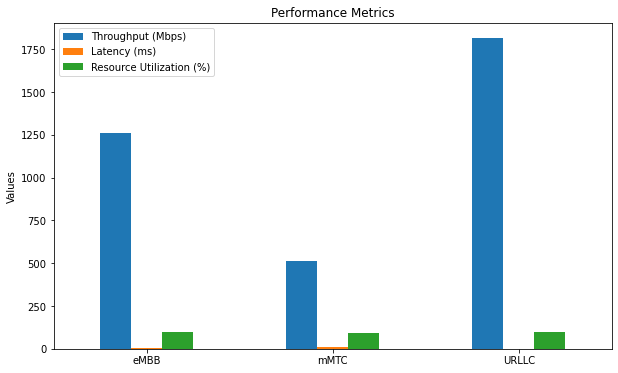

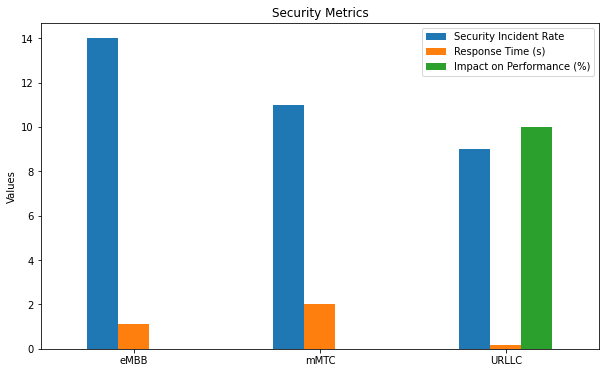

In [83]:
# Performance Visualization
performance_data = pd.DataFrame([embb_performance, mmtc_performance, urllc_performance], index=['eMBB', 'mMTC', 'URLLC'])
performance_data.plot(kind='bar', figsize=(10, 6), title="Performance Metrics", rot=0)
plt.ylabel("Values")
plt.show()

# Security Visualization
security_data = pd.DataFrame([embb_security, mmtc_security, urllc_security], index=['eMBB', 'mMTC', 'URLLC'])
security_data.plot(kind='bar', figsize=(10, 6), title="Security Metrics", rot=0)
plt.ylabel("Values")
plt.show()
